In [2]:

%matplotlib inline 
from matplotlib import style
#FiveThirtyEight style of matplotlib
style.use('fivethirtyeight') 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Pandas - Python data analysis library
import datetime as dt # datetime module of Python

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import os

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
from sqlalchemy import inspect

In [6]:
inspector = inspect(engine)
# Create the inspector and connect it to the engine

In [8]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [15]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect = True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [20]:
# Use the session to query Measurement table and display the first 5 rows
session.flush() # Forcing a flush
for row in session.query(Measurement.id, Measurement.station,Measurement.date,
                         Measurement.prcp,Measurement.tobs).limit(5).all():
    print(row)


(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [14]:
# Use the session to query Station table and display the first 5 rows
session.flush() # Forcing a flush
for row in session.query(Station.id, Station.station,Station.name,Station.latitude,
                         Station.longitude,Station.elevation).limit(5).all():
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


# Exploratory Climate Analysis

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Let's count the total dates we have
total_dates = session.query(func.count(Measurement.date)).first()
# Let's find the earliest date
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
# Let's find the latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Display the dates
print('\033[1m'+"There are {} dates, earliest date: {} and latest date: {}" .format(total_dates[0],earliest_date[0],latest_date[0])+'\033[0m')


There are 19550 dates, earliest date: 2010-01-01 and latest date: 2017-08-23


In [22]:
# Calculate the date 1 year ago from the last data point in the database
# Let's find date 12 months before the latest day
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Display the date
print('\033[1m'+"Date one year back: {}" .format(query_date)+'\033[0m')

Date one year back: 2016-08-23


In [23]:
# Perform a query to retrieve the data and precipitation scores
# Quering "date" and "precipitation" from Measurement table from past one year
Precipitation_one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)
# Let's print the first 10 results from the query
for row in Precipitation_one_year.limit(5).all():
    print(row)

('2016-08-23', 0.0)
('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)


In [24]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Load the query results into a Pandas DataFrame 
df_prcp = pd.DataFrame(Precipitation_one_year, columns=['Date', 'Precipitation'])
# Sorting the DataFrame values by `date`
df_prcp.sort_values(by="Date", ascending=False)
# Display the precipitation dataframe
print('\033[1m'+"The shape of the {} dataframe is: {}" .format("precipitation",df_prcp.shape)+'\033[0m')
df_prcp.head() # Display the first 5 rows of the dataframe

The shape of the precipitation dataframe is: (2230, 2)


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [25]:
# Sort the dataframe by date
df_prcp.dropna(how='all',inplace = True)
# Let's convert the "Date" column to its proper format
df_prcp["Date"] = pd.to_datetime(df_prcp["Date"])
# Let's set the index to the date column
df_prcp.set_index("Date", inplace=True)
# Check if duplicate rows are dropped from the dataframe
print('\033[1m'+"The shape of the final {} dataframe is: {}" .format("precipitation",df_prcp.shape)+'\033[0m')
df_prcp.head()

The shape of the final precipitation dataframe is: (2230, 1)


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


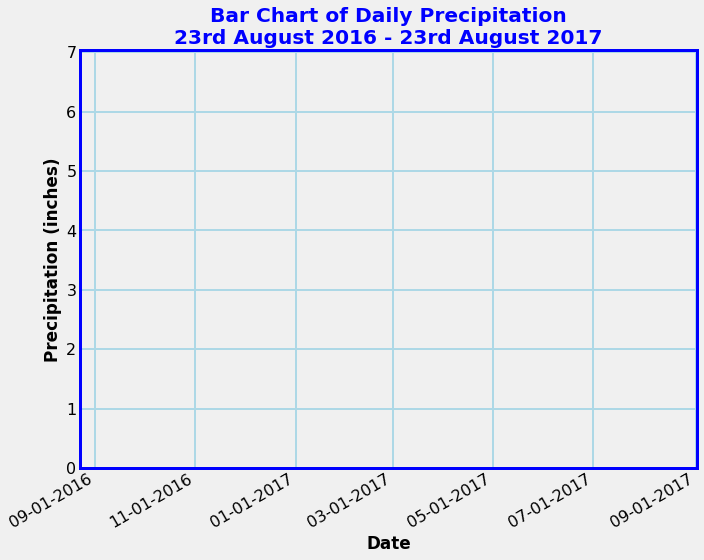

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import timedelta
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df_prcp.index, df_prcp["Precipitation"],color = "blue", edgecolor="white",width = 9)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Customize axis spine
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')    
    
# Set title and labels for axes
ax.set_xlabel("Date",color = "black",fontweight = "bold")
ax.set_ylabel("Precipitation (inches)",color="black",fontweight ="bold")
ax.set_title("Bar Chart of Daily Precipitation\n23rd August 2016 - 23rd August 2017",color="blue",fontweight = "bold")

plt.grid(color="lightblue",linestyle = "solid",linewidth = 2)

#Define the date format
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
# Create upper date limit for x-axis
x_lim_date = dt.date(2017, 8, 23) + dt.timedelta(days=10)
ax.set_xlim(query_date,x_lim_date)

# Rotates and right aligns the x labels & moves the bottom of the axes to make room 
fig.autofmt_xdate()
plt.tight_layout()
# Save the figure
plt.savefig("Images/BarChart_Daily_Prcp.png")
plt.show()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Padas.dataframe.describe generates descriptive statistics 
statistics = df_prcp.describe(include = [np.number])
# Let's make a dataframe from the summary statistics
df_statistics = pd.DataFrame(statistics)
# Formatting the float column
df_statistics = df_statistics.applymap("{0:.2f}".format)
# Rename the column
df_statistics.rename(columns={"Precipitation": "One_year_precipitation"}, inplace=True)
print('\033[1m'+"Shape of statistics dataframe for precipitation data is:{}" .format(df_statistics.shape)+'\033[0m')
df_statistics


Shape of statistics dataframe for precipitation data is:(8, 1)


,One_year_precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [28]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct,func
# Let's count the total stations available in the dataset
total_stations = session.query(func.count(Station.station)).first()
distinct_stations = session.query(func.count(distinct(Station.station))).first()
# Display the count of total stations
print('\033[1m'+"There are {} stations and {} distinct stations" .format(total_stations[0],distinct_stations[0])+'\033[0m')

There are 9 stations and 9 distinct stations


In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Let's design a query grouped by measurement stations and arranged in descending order
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()
# Load the query results into a Pandas DataFrame 
df_active_stations = pd.DataFrame(active_stations, columns=['Station', 'Count'])
# Display the active stations dataframe
print('\033[1m'+"The shape of {} dataframe is: {}" .format("active stations",df_active_stations.shape)+'\033[0m')
df_active_stations

The shape of active stations dataframe is: (9, 2)


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Let's get the most active station from the previous dataframe
most_active_station = df_active_stations.iloc[0,0]
# Display the active stations dataframe
print('\033[1m'+"The most active station is: {}" .format(most_active_station)+'\033[0m')

The most active station is: USC00519281


In [31]:
# Let's order the observed temperatures from Station # USC00519281 to check maximum and minimum values
Max_Temp = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                 order_by(Measurement.tobs.desc()).limit(1).first()
Min_Temp = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                 order_by(Measurement.tobs.asc()).limit(1).first()
# Display the maximum and minimum temperatures from the most active station
print('\033[1m'+"Observed temperatures from {} : Maximum {}F; Minimum {}F" .format(most_active_station,Max_Temp[0],Min_Temp[0])+'\033[0m')

Observed temperatures from USC00519281 : Maximum 85.0F; Minimum 54.0F


In [32]:
# Let's get the maximum, minimum and average temperatures using function method
from sqlalchemy import func
Max_Temp = session.query(func.max(Measurement.tobs).label("Max_Temp")).\
                filter(Measurement.station == most_active_station).first()
Min_Temp = session.query(func.min(Measurement.tobs).label("Min_Temp")).\
                filter(Measurement.station == most_active_station).first()
Avg_Temp = session.query(func.avg(Measurement.tobs).label("Avg_Temp")).\
                filter(Measurement.station == most_active_station).first()
data_list = [[most_active_station,Max_Temp[0],Min_Temp[0],round(Avg_Temp[0],2)]]
df_most_active_station = pd.DataFrame(data_list,columns = ["Most Active Station","Max. Temp(F)","Min. Temp(F)","Avg. Temp(F)"])
df_most_active_station

,Most Active Station,Max. Temp(F),Min. Temp(F),Avg. Temp(F)
0,USC00519281,85.0,54.0,71.66


In [33]:
# Choose the station with the highest number of temperature observations.
# Let's design a query grouped by temperature observations and arranged in descending order
temp_stations = session.query(Measurement.station,func.count(Measurement.tobs)).\
                        group_by(Measurement.station).\
                         order_by(func.count(Measurement.tobs).desc()).all()
# Load the query results into a Pandas DataFrame 
df_temp_stations = pd.DataFrame(temp_stations, columns=['Station', 'Count'])
# Display the active stations dataframe
print('\033[1m'+"The shape of {} dataframe is: {}" .format("temperature stations",df_temp_stations.shape)+'\033[0m')
df_temp_stations





The shape of temperature stations dataframe is: (9, 2)


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [34]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Let's get the most active station from the previous dataframe
most_temp_station = df_temp_stations.iloc[0,0]
# Quering "date" and "precipitation" from Measurement table from past one year
Temp_one_year = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= query_date).\
                        filter(Measurement.station == most_temp_station)
# Load the query results into a Pandas DataFrame 
df_temp = pd.DataFrame(Temp_one_year, columns=['Date', 'Temperature'])
# Display the active stations dataframe
print('\033[1m'+"Shape of {} dataframe with temperature readings for past 12 months: {}" .format(most_temp_station,df_temp.shape)+'\033[0m')
df_temp.head() # Display the first 5 rows

Shape of USC00519281 dataframe with temperature readings for past 12 months: (352, 2)


,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
